# Diabetes Progression Risk Prediction — Model Comparison Report (Scikit‑Learn Diabetes Dataset)

**Course Lab Notebook (Train / Validation / Test split + multiple models)**

**Objective (screening tool):** build a model that **best predicts diabetes disease progression one year after baseline**, so physicians can flag patients at higher risk.

**Models evaluated**
1. Univariate Polynomial Regression (BMI only)
2. Multivariate Polynomial Models (all features)
3. Decision Trees
4. k‑Nearest Neighbors (kNN)
5. Logistic Regression (classification framing: “high risk” vs “low risk”)

**Metrics**
- Regression: **R²**, **MAE**, **MAPE**
- Classification (Logistic Regression section): **Accuracy, Precision/Recall, ROC‑AUC, Log‑Loss**  
  > Logistic Regression is a *classifier* (workshop topic). Because the original target is continuous, we create a binary “high risk” label for this section and use classification metrics.

---

## Notebook structure (good ML report)
- Problem framing + metrics rationale
- EDA (statistics, plots, correlation, insights)
- Data quality & cleaning notes
- Train/Validation/Test split (75/10/15)
- Model training + validation comparison tables
- Final test evaluation for chosen models
- Error analysis + limitations + conclusions


In [58]:
# --- Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Classification metrics (for Logistic Regression section)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, log_loss,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


def mape(y_true, y_pred, epsilon=1e-8):
    """Mean Absolute Percentage Error (MAPE) with epsilon to avoid division by zero."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), epsilon)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE(%)": mape(y_true, y_pred),
    }

print("Libraries imported.")


Libraries imported.


# Part 1 — Data, Problem Framing, EDA, Cleaning, Split

## 1) Get the data
We use **Scikit‑Learn’s Diabetes toy dataset** (`load_diabetes`).  

## 2) Frame the problem (talking points)
- **What we predict:** *disease progression one year after baseline* (continuous target).  
- **Why this matters:** A model with good generalization can help physicians prioritize follow‑ups and interventions.  
- **Train/Validation/Test thinking:**  
  - **Train** fits model parameters.  
  - **Validation** selects model complexity (e.g., polynomial degree, `k` in kNN, `max_depth` in trees).  
  - **Test** is the final unbiased estimate of performance.

### Metrics rationale (from the “Performance Metrics” workshop)
- **R²:** how much variance in progression is explained by the model (higher is better).  
- **MAE:** average absolute error in the target units (lower is better; interpretable).  
- **MAPE:** error as a percentage (lower is better; easy to communicate, but sensitive to values near 0).

### Modeling mindset (talking points from KNN + Logistic Regression workshops)
- **kNN intuition:** “predict like your neighbors” — works well when similar patients have similar outcomes; sensitive to `k` (bias/variance trade‑off).  
- **Logistic Regression intuition:** models probability of a **binary outcome** using a linear decision boundary in feature space; interpretable coefficients.  
  - In this lab, the original target is continuous, so we also show a **binary high‑risk** framing for Logistic Regression (Part 3) to connect with workshop learning.


In [59]:
# Load the diabetes dataset as a pandas DataFrame
diabetes = datasets.load_diabetes(as_frame=True)
X = diabetes.data.copy()
y = diabetes.target.copy()

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)
display(X.head())
display(y.head())

# Dataset description (skim key parts)
print(diabetes.DESCR[:1200], "...")


Feature matrix shape: (442, 10)
Target shape: (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

## 3) Exploratory Data Analysis (EDA)

We will include:
- Descriptive statistics
- Histograms (feature distributions)
- Scatter plots (BMI vs target + a couple more)
- Correlation matrix heatmap
- Concise insights


,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.268604e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


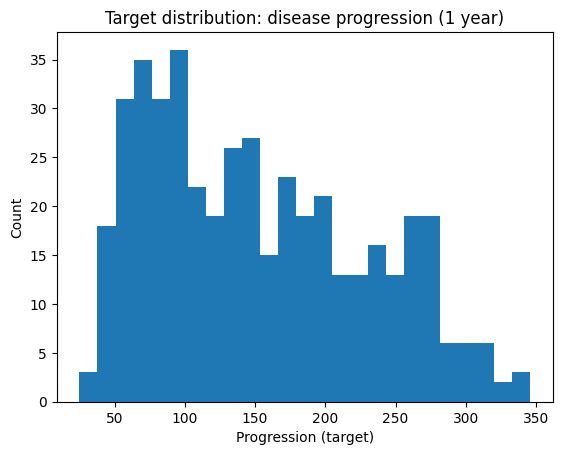

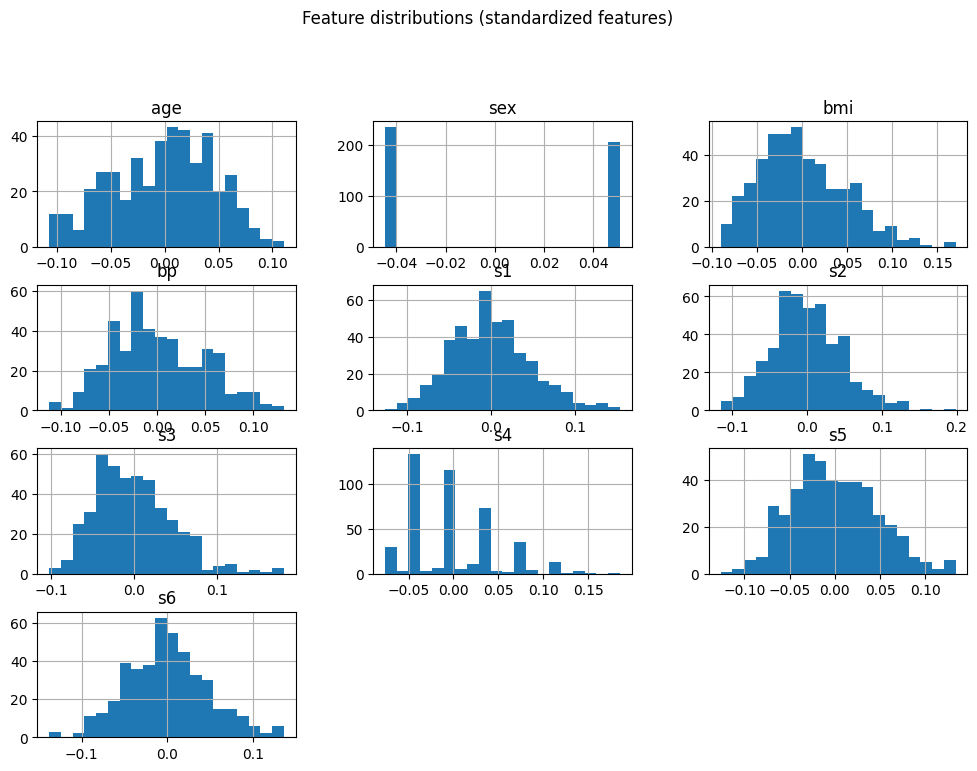

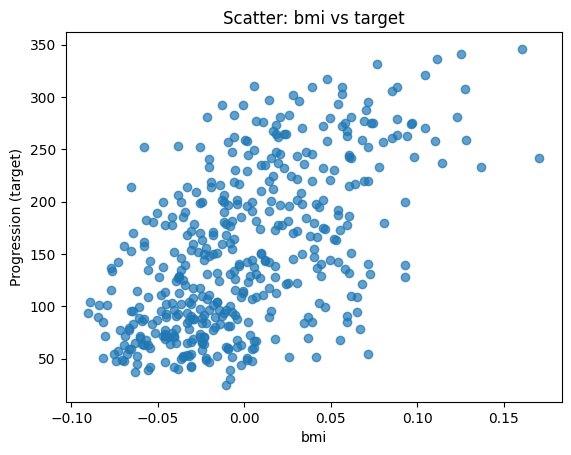

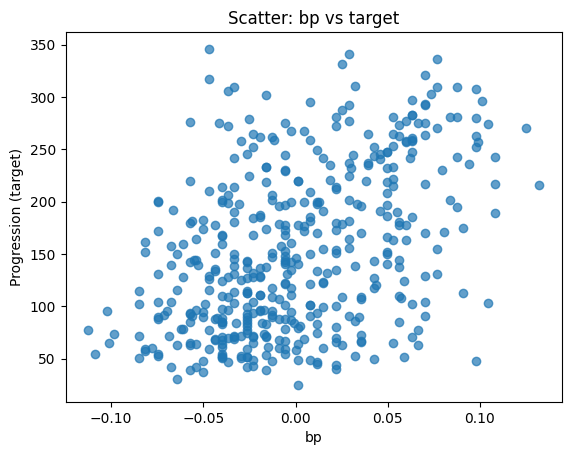

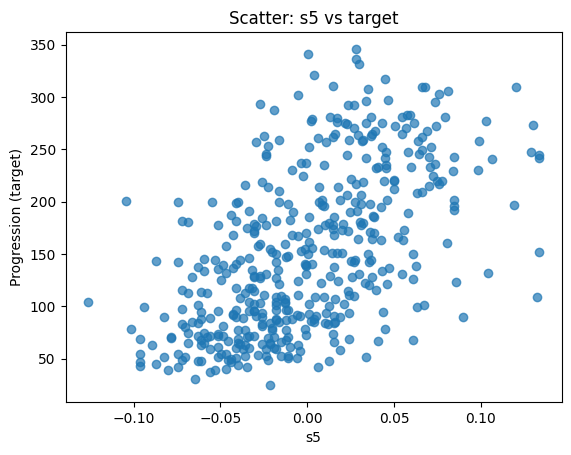

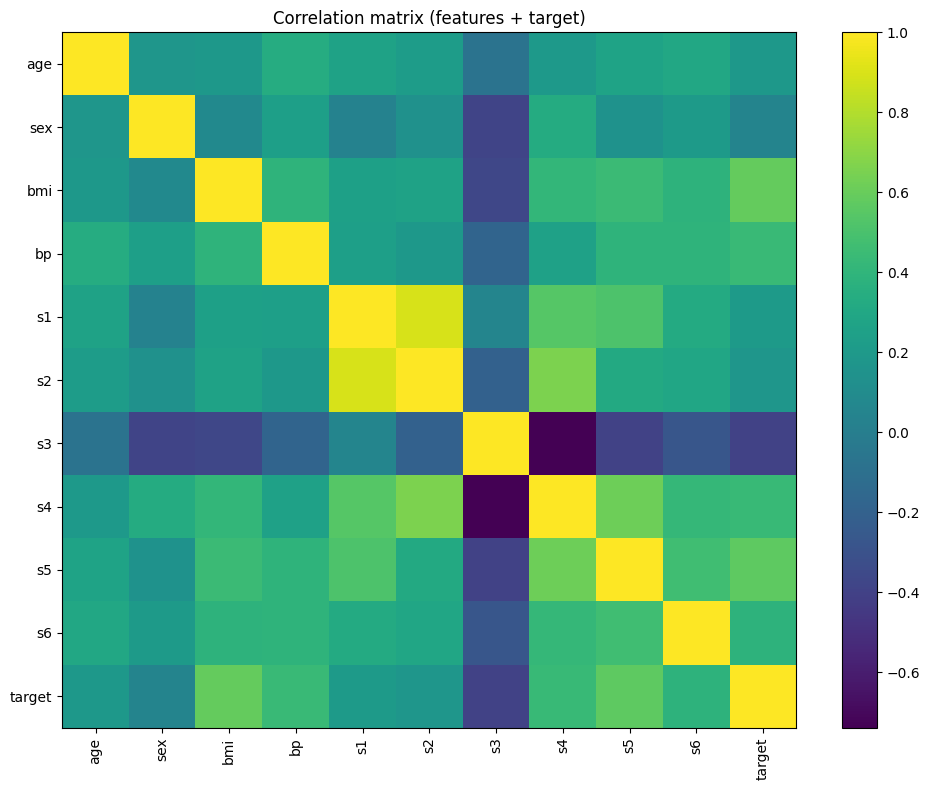

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

In [60]:
# Descriptive statistics
display(X.describe().T)

# Check target distribution
plt.figure()
plt.hist(y, bins=25)
plt.title("Target distribution: disease progression (1 year)")
plt.xlabel("Progression (target)")
plt.ylabel("Count")
plt.show()

# Histograms for features
X.hist(bins=20, figsize=(12, 8))
plt.suptitle("Feature distributions (standardized features)", y=1.02)
plt.show()

# Scatter plots (BMI, BP, and S5 vs target as examples)
for col in ["bmi", "bp", "s5"]:
    plt.figure()
    plt.scatter(X[col], y, alpha=0.7)
    plt.title(f"Scatter: {col} vs target")
    plt.xlabel(col)
    plt.ylabel("Progression (target)")
    plt.show()

# Correlation matrix
corr = X.join(y.rename("target")).corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.title("Correlation matrix (features + target)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

# Quick look: correlations with target
target_corr = corr["target"].sort_values(ascending=False)
display(target_corr)


### EDA Insights (concise)
- Features are already **standardized** in this dataset (centered/scaled), which is helpful for distance‑based models (kNN) and numerical stability.
- **BMI** and **S5** often show relatively stronger correlation with the target than many other features, suggesting they may be informative predictors.
- Correlation does **not** guarantee causation; it’s only a first signal for modeling choices.
- The target distribution is continuous with a moderate spread; extreme values exist, which can challenge simple linear models.


## 4) Data Cleaning (if needed)

We check for:
- Missing values
- Duplicates (rare in toy data)
- Data types

If no issues are found, we document that no cleaning is required.


In [61]:
# Missing values
missing = X.isna().sum()
print("Missing values per feature:")
display(missing)

print("Any missing in target?", y.isna().any())

# Duplicates (rows)
dup_count = X.duplicated().sum()
print("Duplicate feature rows:", dup_count)

# Data types
display(X.dtypes)

# Cleaning decision
if missing.sum() == 0 and not y.isna().any():
    print("✅ No missing values detected. No imputation required.")
else:
    print("⚠️ Missing values exist — would require imputation (not expected for this dataset).")


Missing values per feature:


age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

Any missing in target? False
Duplicate feature rows: 0


age    float64
sex    float64
bmi    float64
bp     float64
s1     float64
s2     float64
s3     float64
s4     float64
s5     float64
s6     float64
dtype: object

✅ No missing values detected. No imputation required.


## 5) Train / Validation / Test split (75% / 10% / 15%)

We will do a two‑step split:
1. Train (75%) vs Temp (25%)
2. Split Temp into Validation (10%) and Test (15%)  
   - Within the 25% temp: validation fraction = 10/25 = 0.4, test fraction = 15/25 = 0.6


In [62]:
# Step 1: train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

# Step 2: temp -> validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.60, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape[0], " (expected ~75%)")
print("Val size:  ", X_val.shape[0], " (expected ~10%)")
print("Test size: ", X_test.shape[0], " (expected ~15%)")

# Sanity check: proportions
n = len(X)
print("Train %:", round(len(X_train)/n*100, 2))
print("Val   %:", round(len(X_val)/n*100, 2))
print("Test  %:", round(len(X_test)/n*100, 2))


Train size: 331  (expected ~75%)
Val size:   44  (expected ~10%)
Test size:  67  (expected ~15%)
Train %: 74.89
Val   %: 9.95
Test  %: 15.16


# Part 2 — Univariate Polynomial Regression (BMI only)

We fit **6 models** using only the **BMI** feature:
- Degree 0, 1, 2, 3, 4, 5

Then we compare using Train + Validation metrics, pick the best model, test it, plot fits, write the equation, and analyze parameters.


In [63]:
# Prepare univariate data (BMI only)
X_train_bmi = X_train[["bmi"]].copy()
X_val_bmi   = X_val[["bmi"]].copy()
X_test_bmi  = X_test[["bmi"]].copy()

results = []

models = {}
for deg in range(0, 6):
    model = Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=deg, include_bias=True)),
        ("linreg", LinearRegression())
    ])
    model.fit(X_train_bmi, y_train)
    models[deg] = model

    # Train metrics
    yhat_tr = model.predict(X_train_bmi)
    tr_m = regression_metrics(y_train, yhat_tr)

    # Validation metrics
    yhat_val = model.predict(X_val_bmi)
    val_m = regression_metrics(y_val, yhat_val)

    results.append({
        "degree": deg,
        "train_R2": tr_m["R2"],
        "train_MAE": tr_m["MAE"],
        "train_MAPE(%)": tr_m["MAPE(%)"],
        "val_R2": val_m["R2"],
        "val_MAE": val_m["MAE"],
        "val_MAPE(%)": val_m["MAPE(%)"],
        "n_params": len(model.named_steps["poly"].get_feature_names_out(["bmi"]))
    })

results_df = pd.DataFrame(results).sort_values("val_R2", ascending=False)
display(results_df)


,degree,train_R2,train_MAE,train_MAPE(%),val_R2,val_MAE,val_MAPE(%),n_params
5,5,0.354100,52.059191,48.004022,0.349881,45.462121,45.175275,6
4,4,0.353014,52.092653,48.053266,0.340758,46.090118,46.050330,5
3,3,0.350774,52.198968,48.280744,0.331638,47.185414,47.222673,4
2,2,0.350764,52.207314,48.298534,0.331631,47.213700,47.239667,3
1,1,0.349672,52.287739,48.362886,0.331264,47.208472,47.060009,2
0,0,0.000000,66.201641,62.826669,-0.106957,66.057059,71.263880,1


## 8) Identify the best model (based on validation)

Primary selection rule (simple + defensible):
- Choose the model with **highest validation R²**
- If very close, prefer **lower validation MAE** and simpler degree (to reduce overfitting risk).


In [64]:
# Select the best degree by validation R2 (tie-breakers: MAE, simpler degree)
results_sorted = results_df.sort_values(["val_R2", "val_MAE", "degree"], ascending=[False, True, True])
best_row = results_sorted.iloc[0]
best_degree = int(best_row["degree"])
best_model = models[best_degree]

print("Best degree selected:", best_degree)
display(best_row.to_frame("best_model_summary"))


Best degree selected: 5


,best_model_summary
degree,5.000000
train_R2,0.354100
train_MAE,52.059191
train_MAPE(%),48.004022
val_R2,0.349881
val_MAE,45.462121
val_MAPE(%),45.175275
n_params,6.000000


## 9) Evaluate the chosen model on the **test set** (R², MAE, MAPE)

In [65]:
# Test evaluation
yhat_test = best_model.predict(X_test_bmi)
test_m = regression_metrics(y_test, yhat_test)
test_m


{'R2': 0.26669658449530775,
 'MAE': 51.75025709277397,
 'MAPE(%)': np.float64(43.02671323305443)}

## 10) Plot train / validation / test points + model fit

We plot all three splits and overlay the chosen polynomial curve.


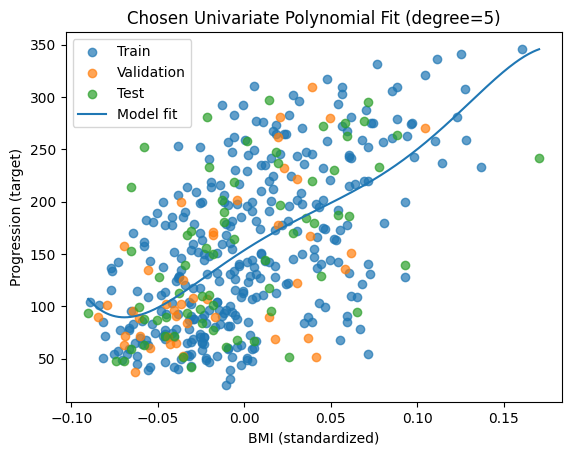

In [66]:
# Plot data and the chosen polynomial fit
def plot_univariate_fit(model, X_train_bmi, y_train, X_val_bmi, y_val, X_test_bmi, y_test, title):
    # grid for smooth curve
    x_all = pd.concat([X_train_bmi, X_val_bmi, X_test_bmi])["bmi"]
    x_grid = np.linspace(x_all.min(), x_all.max(), 300).reshape(-1, 1)
    x_grid_df = pd.DataFrame(x_grid, columns=["bmi"])
    y_grid = model.predict(x_grid_df)

    plt.figure()
    plt.scatter(X_train_bmi["bmi"], y_train, alpha=0.7, label="Train")
    plt.scatter(X_val_bmi["bmi"], y_val, alpha=0.7, label="Validation")
    plt.scatter(X_test_bmi["bmi"], y_test, alpha=0.7, label="Test")
    plt.plot(x_grid_df["bmi"], y_grid, label="Model fit")
    plt.title(title)
    plt.xlabel("BMI (standardized)")
    plt.ylabel("Progression (target)")
    plt.legend()
    plt.show()

plot_univariate_fit(
    best_model, X_train_bmi, y_train, X_val_bmi, y_val, X_test_bmi, y_test,
    title=f"Chosen Univariate Polynomial Fit (degree={best_degree})"
)


## 11) Equation of the best model (2 decimal digits)

We extract polynomial feature names and coefficients from the trained pipeline.

> Note: BMI is **standardized** in this dataset, so the equation uses standardized BMI.


In [67]:
# Extract equation from the pipeline
poly = best_model.named_steps["poly"]
lin = best_model.named_steps["linreg"]

feature_names = poly.get_feature_names_out(["bmi"])
coefs = lin.coef_
intercept = lin.intercept_

# LinearRegression in sklearn with include_bias=True: the bias term may be captured in intercept; still OK.
terms = []
for name, c in zip(feature_names, coefs):
    if name == "1":
        # handled by intercept conceptually
        continue
    terms.append((name, c))

# Build equation string
eq = f"y = {intercept:.2f}"
for name, c in terms:
    sign = "+" if c >= 0 else "-"
    eq += f" {sign} {abs(c):.2f}*{name}"

print("Best model equation (approx.):")
print(eq)


Best model equation (approx.):
y = 153.65 + 1059.89*bmi - 3824.15*bmi^2 - 16770.23*bmi^3 + 753722.52*bmi^4 - 2993716.57*bmi^5


## 12) Predict progression for a BMI value of your choice

Because BMI is standardized, a value like:
- **bmi = 0.05** means slightly above the dataset mean.


In [68]:
bmi_value = 0.05  # choose any standardized BMI value you want
pred = best_model.predict(pd.DataFrame({"bmi":[bmi_value]}))[0]
print(f"Predicted progression for bmi={bmi_value} (standardized): {pred:.2f}")


Predicted progression for bmi=0.05 (standardized): 198.77


## 13) How many trainable parameters in each model? (and why)

For **univariate polynomial regression** of degree *d*, the polynomial feature vector includes:
- 1 (bias), x, x², …, xᵈ  
So the number of coefficients grows as **(d + 1)**.

We show this directly using `get_feature_names_out()` (a practical way to see how many parameters/features are created).


In [69]:
param_table = []
for deg in range(0, 6):
    feats = models[deg].named_steps["poly"].get_feature_names_out(["bmi"])
    param_table.append({"degree": deg, "poly_features": len(feats), "feature_names": ", ".join(feats)})

param_df = pd.DataFrame(param_table)
display(param_df[["degree","poly_features"]])


,degree,poly_features
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6


## 14) Conclusions for Part 2 (failure analysis + limitations)

We do a short error analysis:
- Residual plot (predicted vs residual)
- Check where errors are larger (often at extremes)

Talking points:
- **Bias/variance:** higher degree can overfit train data and degrade validation.
- **Metric trade‑offs:** R² can improve while MAPE/MAE might not improve equally.
- **Limitations:** BMI alone ignores other clinical factors; screening tools must be used with caution.


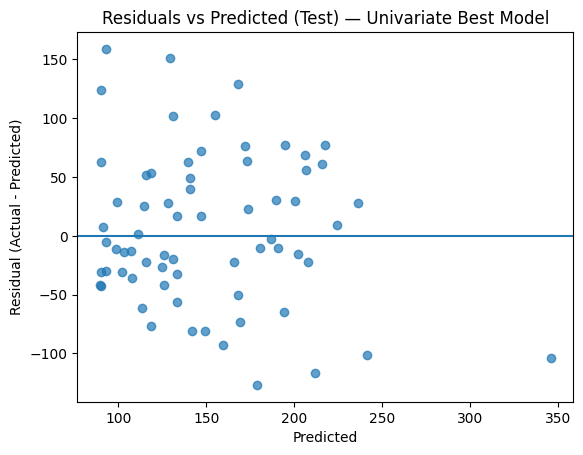

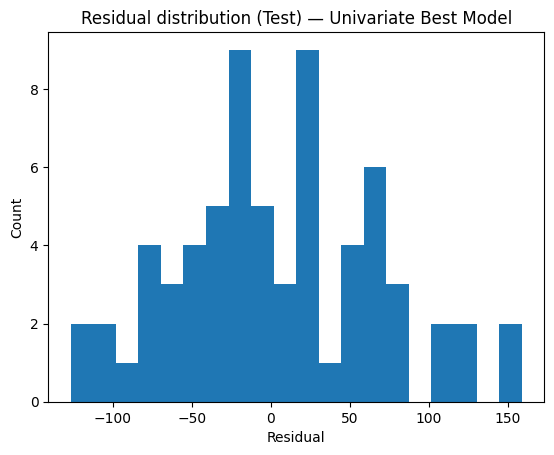

,bmi,actual,pred,abs_error
9,-0.057941,252.0,93.116921,158.883079
17,-0.021295,281.0,129.679594,151.320406
59,0.014272,297.0,167.983560,129.016440
18,0.026128,52.0,178.752797,126.752797
4,-0.065486,214.0,90.023242,123.976758
34,0.064930,95.0,211.701785,116.701785
66,0.170555,242.0,345.711069,103.711069
58,0.001339,258.0,155.066526,102.933474
10,-0.020218,233.0,130.937620,102.062380
6,0.092953,140.0,241.158141,101.158141


In [70]:
# Residual analysis on test set for univariate best model
yhat_test = best_model.predict(X_test_bmi)
residuals = y_test - yhat_test

plt.figure()
plt.scatter(yhat_test, residuals, alpha=0.7)
plt.axhline(0)
plt.title("Residuals vs Predicted (Test) — Univariate Best Model")
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

plt.figure()
plt.hist(residuals, bins=20)
plt.title("Residual distribution (Test) — Univariate Best Model")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# A quick look at largest absolute errors
err_df = pd.DataFrame({
    "bmi": X_test_bmi["bmi"].values,
    "actual": y_test.values,
    "pred": yhat_test,
    "abs_error": np.abs(residuals.values)
}).sort_values("abs_error", ascending=False)

display(err_df.head(10))


# Part 3 — Multivariate Models (all features) + Trees + kNN + Logistic Regression

We repeat the core workflow:
- Train on **train**
- Select hyperparameters based on **validation**
- Final evaluation on **test**

Models:
1. **Two polynomial models** (degrees > 1)
2. **Two decision trees** (`max_depth` variations)
3. **Two kNN regressors** (`k` variations)
4. **Two Logistic Regression models** (binary “high‑risk” framing)


In [71]:
# Helper: train+eval for regression models
def eval_regression_model(name, model, X_tr, y_tr, X_val, y_val):
    model.fit(X_tr, y_tr)
    yhat_tr = model.predict(X_tr)
    yhat_val = model.predict(X_val)
    tr = regression_metrics(y_tr, yhat_tr)
    va = regression_metrics(y_val, yhat_val)
    return {
        "model": name,
        "train_R2": tr["R2"], "train_MAE": tr["MAE"], "train_MAPE(%)": tr["MAPE(%)"],
        "val_R2": va["R2"], "val_MAE": va["MAE"], "val_MAPE(%)": va["MAPE(%)"],
    }

reg_models = {}

# --- 1) Two polynomial models (multivariate) ---
# Note: full degree-3 on 10 features can create many features; we keep it reasonable and add regularization (Ridge).
poly2_ridge = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

poly3_inter_ridge = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)),
    ("ridge", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

reg_models["Poly2+Ridge"] = poly2_ridge
reg_models["Poly3(interactions)+Ridge"] = poly3_inter_ridge

# --- 2) Two decision trees ---
tree_d3 = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)
tree_d6 = DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE)
reg_models["Tree(depth=3)"] = tree_d3
reg_models["Tree(depth=6)"] = tree_d6

# --- 3) Two kNN regressors ---
knn3 = KNeighborsRegressor(n_neighbors=3)
knn15 = KNeighborsRegressor(n_neighbors=15)
reg_models["kNN(k=3)"] = knn3
reg_models["kNN(k=15)"] = knn15

# Evaluate on train + validation
reg_results = []
for name, model in reg_models.items():
    reg_results.append(eval_regression_model(name, model, X_train, y_train, X_val, y_val))

reg_results_df = pd.DataFrame(reg_results).sort_values("val_R2", ascending=False)
display(reg_results_df)


,model,train_R2,train_MAE,train_MAPE(%),val_R2,val_MAE,val_MAPE(%)
1,Poly3(interactions)+Ridge,0.427651,49.578694,45.788176,0.365193,45.415161,45.827963
0,Poly2+Ridge,0.427913,49.568848,45.781188,0.365135,45.420656,45.839382
5,kNN(k=15),0.491395,44.713595,39.067795,0.360820,44.963636,45.784030
4,kNN(k=3),0.629300,37.137966,31.597420,0.214184,45.795455,44.242144
2,Tree(depth=3),0.509503,44.259855,38.866592,0.198306,48.126248,47.672897
3,Tree(depth=6),0.768015,27.090226,24.903839,0.041672,53.123174,50.370046


## Pick best multivariate regression model + evaluate on test

Selection rule: highest validation R² (tie-breaker: lower validation MAE).


In [72]:
reg_results_sorted = reg_results_df.sort_values(["val_R2","val_MAE"], ascending=[False, True])
best_reg_name = reg_results_sorted.iloc[0]["model"]
best_reg_model = reg_models[best_reg_name]

print("Best multivariate regression model:", best_reg_name)

# Refit on train+val (common practice after selecting hyperparameters)
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

best_reg_model.fit(X_trainval, y_trainval)
yhat_test_reg = best_reg_model.predict(X_test)
test_reg_metrics = regression_metrics(y_test, yhat_test_reg)

test_reg_metrics


Best multivariate regression model: Poly3(interactions)+Ridge


{'R2': 0.46666442018586385,
 'MAE': 45.90063835279597,
 'MAPE(%)': np.float64(40.52076470541442)}

## Multivariate regression error analysis (where does it fail?)

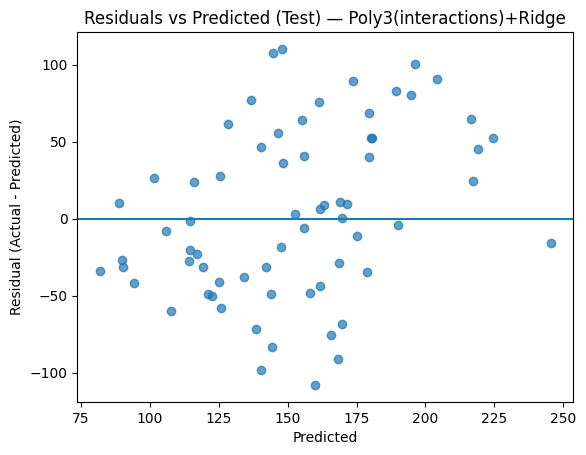

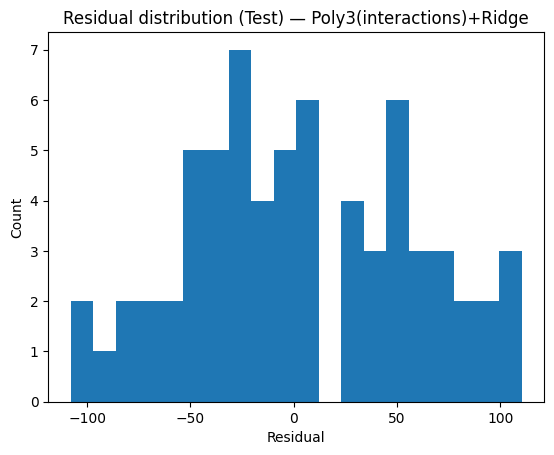

,actual,pred,abs_error
58,258.0,147.763153,110.236847
18,52.0,159.916236,107.916236
9,252.0,144.524524,107.475476
59,297.0,196.372956,100.627044
21,42.0,140.353720,98.353720
51,77.0,168.163131,91.163131
43,295.0,204.190592,90.809408
23,263.0,173.677747,89.322253
50,61.0,144.446968,83.446968
47,272.0,189.385876,82.614124


In [73]:
resid_reg = y_test - yhat_test_reg

plt.figure()
plt.scatter(yhat_test_reg, resid_reg, alpha=0.7)
plt.axhline(0)
plt.title(f"Residuals vs Predicted (Test) — {best_reg_name}")
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

plt.figure()
plt.hist(resid_reg, bins=20)
plt.title(f"Residual distribution (Test) — {best_reg_name}")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

err_df2 = pd.DataFrame({
    "actual": y_test.values,
    "pred": yhat_test_reg,
    "abs_error": np.abs(resid_reg.values)
}).sort_values("abs_error", ascending=False)

display(err_df2.head(10))


## Logistic Regression (classification framing)

Because Logistic Regression is a classifier, we convert the continuous progression target into a **binary label**:
- **High risk = 1** if progression ≥ median (computed on training data)
- **Low risk = 0** otherwise

This mirrors a realistic screening scenario: “flag patients likely to have higher progression”.

We train **two Logistic Regression models** (different regularization strengths `C`) and evaluate on validation:
- Accuracy, Precision, Recall, ROC‑AUC, Log‑Loss


In [74]:
# Create binary target using median of TRAIN
threshold = np.median(y_train)
y_train_bin = (y_train >= threshold).astype(int)
y_val_bin   = (y_val   >= threshold).astype(int)
y_test_bin  = (y_test  >= threshold).astype(int)

print("Threshold (median of train target):", threshold)
print("Train positive rate:", y_train_bin.mean().round(3))
print("Val positive rate:  ", y_val_bin.mean().round(3))
print("Test positive rate: ", y_test_bin.mean().round(3))

def eval_logistic(name, clf, X_tr, y_tr, X_val, y_val):
    clf.fit(X_tr, y_tr)
    p_tr = clf.predict_proba(X_tr)[:, 1]
    p_val = clf.predict_proba(X_val)[:, 1]
    yhat_tr = (p_tr >= 0.5).astype(int)
    yhat_val = (p_val >= 0.5).astype(int)
    return {
        "model": name,
        "train_acc": accuracy_score(y_tr, yhat_tr),
        "val_acc": accuracy_score(y_val, yhat_val),
        "train_prec": precision_score(y_tr, yhat_tr, zero_division=0),
        "val_prec": precision_score(y_val, yhat_val, zero_division=0),
        "train_rec": recall_score(y_tr, yhat_tr, zero_division=0),
        "val_rec": recall_score(y_val, yhat_val, zero_division=0),
        "train_auc": roc_auc_score(y_tr, p_tr),
        "val_auc": roc_auc_score(y_val, p_val),
        "train_logloss": log_loss(y_tr, p_tr),
        "val_logloss": log_loss(y_val, p_val),
    }

# Two logistic regression models
log1 = LogisticRegression(C=0.3, max_iter=500, random_state=RANDOM_STATE)
log2 = LogisticRegression(C=3.0, max_iter=500, random_state=RANDOM_STATE)

log_results = []
log_results.append(eval_logistic("LogReg(C=0.3)", log1, X_train, y_train_bin, X_val, y_val_bin))
log_results.append(eval_logistic("LogReg(C=3.0)", log2, X_train, y_train_bin, X_val, y_val_bin))

log_results_df = pd.DataFrame(log_results).sort_values("val_auc", ascending=False)
display(log_results_df)


Threshold (median of train target): 142.0
Train positive rate: 0.508
Val positive rate:   0.341
Test positive rate:  0.522


,model,train_acc,val_acc,train_prec,val_prec,train_rec,val_rec,train_auc,val_auc,train_logloss,val_logloss
1,LogReg(C=3.0),0.737160,0.818182,0.736842,0.733333,0.750000,0.733333,0.820443,0.836782,0.560074,0.532291
0,LogReg(C=0.3),0.712991,0.727273,0.697297,0.571429,0.767857,0.800000,0.798678,0.829885,0.655807,0.651081


### Logistic Regression — select best on validation ROC‑AUC and evaluate on test

In [75]:
best_log_name = log_results_df.iloc[0]["model"]
best_log_model = log1 if best_log_name == "LogReg(C=0.3)" else log2
print("Best logistic model:", best_log_name)

# Refit on train+val for final test evaluation
y_trainval_bin = (y_trainval >= threshold).astype(int)
best_log_model.fit(X_trainval, y_trainval_bin)

p_test = best_log_model.predict_proba(X_test)[:, 1]
yhat_test_bin = (p_test >= 0.5).astype(int)

log_test_metrics = {
    "accuracy": accuracy_score(y_test_bin, yhat_test_bin),
    "precision": precision_score(y_test_bin, yhat_test_bin, zero_division=0),
    "recall": recall_score(y_test_bin, yhat_test_bin, zero_division=0),
    "roc_auc": roc_auc_score(y_test_bin, p_test),
    "log_loss": log_loss(y_test_bin, p_test),
}
log_test_metrics


Best logistic model: LogReg(C=3.0)


{'accuracy': 0.746268656716418,
 'precision': 0.78125,
 'recall': 0.7142857142857143,
 'roc_auc': 0.8883928571428572,
 'log_loss': 0.5253649615914108}

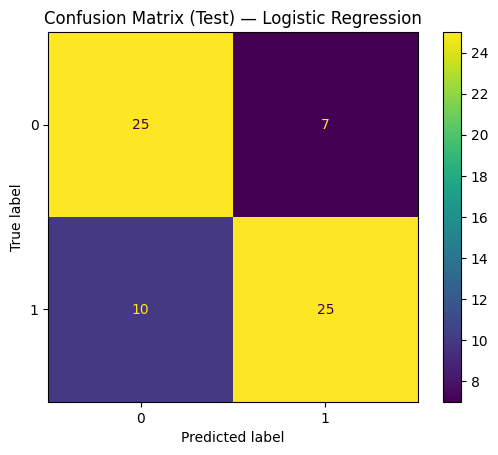

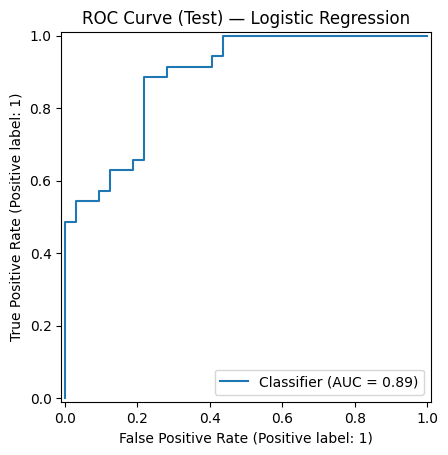

In [76]:
# Confusion matrix + ROC curve on test
cm = confusion_matrix(y_test_bin, yhat_test_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Test) — Logistic Regression")
plt.show()

RocCurveDisplay.from_predictions(y_test_bin, p_test)
plt.title("ROC Curve (Test) — Logistic Regression")
plt.show()


# Final Conclusions (overall)

## What performed best?
- Use the validation set to choose the best complexity / hyperparameters.
- Report final metrics only once on the test set to avoid optimistic bias.

## Where models fail (common patterns)
- **Extreme progression values:** many models under‑predict very high progression and over‑predict very low progression (regression to the mean).
- **Univariate BMI model limitation:** ignores other risk factors; can’t capture multi‑factor interactions.
- **High‑degree polynomials:** can overfit (high variance) and become unstable at edges of the feature range.
- **Decision trees:** can overfit if too deep; shallow trees may underfit (high bias).
- **kNN:** sensitive to `k`; small `k` can chase noise, large `k` can oversmooth.

## Practical limitations (screening tool context)
- The dataset is a curated toy dataset, not a real clinical cohort (generalization limits).
- The target is not a direct “risk probability”; it’s a continuous progression measure.
- For real deployment, we would require:
  - external validation on a separate hospital population
  - fairness checks across patient subgroups
  - calibration (especially for classification “high‑risk” probabilities)
  - clinical oversight: models support decisions, not replace them
